# Importing libraries

In [2]:
# %conda install wordcloud
%conda install tensorflow


Note: you may need to restart the kernel to use updated packages.Collecting package metadata (current_repodata.json): ...working... done

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: d:\Anaconda

  added / updated specs:
    - tensorflow


The following NEW packages will be INSTALLED:

  _tflow_select      pkgs/main/win-64::_tflow_select-2.3.0-mkl 
  absl-py            pkgs/main/win-64::absl-py-1.3.0-py310haa95532_0 
  aiohttp            pkgs/main/win-64::aiohttp-3.8.3-py310h2bbff1b_0 
  aiosignal          pkgs/main/noarch::aiosignal-1.2.0-pyhd3eb1b0_0 
  astunparse         pkgs/main/noarch::astunparse-1.6.3-py_0 
  async-timeout      pkgs/main/win-64::async-timeout-4.0.2-py310haa95532_0 
  blinker            pkgs/main/win-64::b

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import os,re
import warnings
warnings.filterwarnings('ignore')
import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import tensorflow as tf
from tqdm import tqdm, trange
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification

reading dataset

In [4]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

checking for null values

In [5]:
train_df.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [6]:
test_df.isnull().sum()

ID          0
TITLE       0
ABSTRACT    0
dtype: int64

number of classes

In [7]:
cols = train_df.columns
label_cols = list(cols[3:9])
label_cols

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

# Data visualization and preprocessing

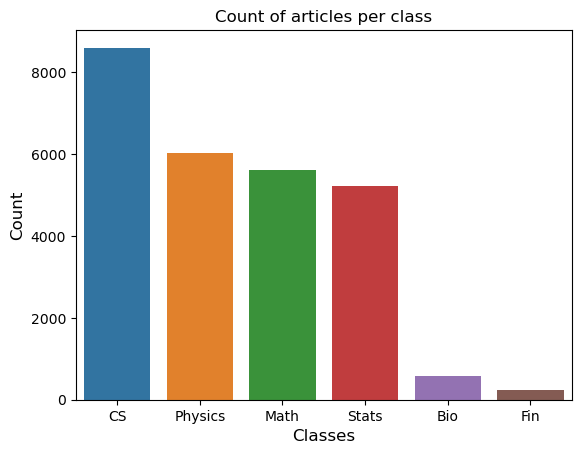

In [9]:
# plotting number of classes and their count of articles
sns.barplot(x=['CS','Physics','Math','Stats','Bio','Fin'], y=train_df.iloc[:,3:9].sum().values)
plt.title('Count of articles per class')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Melzarr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
# stopwords list and stemmer 
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

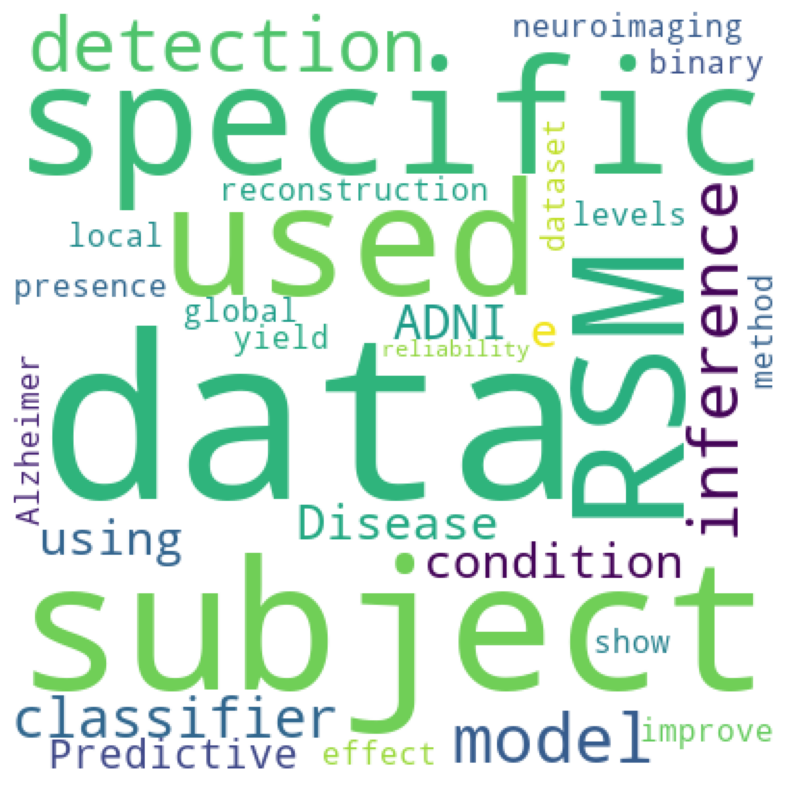

In [13]:
# plotting wordcloud 
wordcloud = WordCloud(width = 400, height = 400, background_color ='white', stopwords = stop_words, 
                min_font_size = 10).generate(train_df['ABSTRACT'][0]) 
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.show()

function for cleaning data

In [14]:
def clean_text(df):
  for i in range(0,len(df)):
    text = re.sub('[^a-zA-Z]', ' ', df['ABSTRACT'][i])
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    df['ABSTRACT'][i] = text
  return df

In [15]:
# cleaning train data 
train_df = clean_text(train_df)

In [16]:
# cleaning train data 
test_df = clean_text(test_df)

converting train data classes into one hot label list

In [17]:
train_df['one_hot_labels'] = list(train_df[label_cols].values)
labels = list(train_df['one_hot_labels'].values)
abstract = list(train_df['ABSTRACT'].values)

In [18]:
# average abstract length
train_df.insert(10,'Length',0)
for i in range(0,len(train_df)):
  train_df['Length'][i] = len(train_df['ABSTRACT'][i])
train_df['Length'].mean()

630.3024508868968

initalise max length , bert tokenizer and encoding train data

less length in order to avoid memory error 

In [19]:
max_length = 200
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encodings = tokenizer.batch_encode_plus(abstract,max_length=max_length,pad_to_max_length=True,truncation=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# loading necessary encoded values 
input_ids = encodings['input_ids'] 
token_type_ids = encodings['token_type_ids'] 
attention_masks = encodings['attention_mask']

In [21]:
# splitting data into training and validation
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels,
token_type_ids,attention_masks, random_state=200, test_size=0.20)

In [22]:
# converting all numpy arrays to tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [23]:
# initialise batch size 
batch_size = 32

In [24]:
# creating data loader and loading data into it using random sampler
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [25]:
# saving data loaders
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [26]:
# loading pretrained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [29]:
# enabling GPU
if torch.cuda.is_available():
    model.cuda()
else:
    print('using cpu bruh')

using cpu bruh


In [31]:
from transformers import AdamW

In [32]:
# initialising optimizer
optimizer = AdamW(model.parameters(),lr=3e-5,correct_bias=True)

In [33]:
# device name of GPU
device = 'cuda'
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

# Training and Validation

In [ ]:
epochs = 4
val_acc_list = []
for _ in trange(epochs, desc="Epoch"):

  # set model to training mode 
  model.train()

  # train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # clearing the gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    # converting logits and labels to appropriate shape 
    loss = loss_func(logits.view(-1,6),b_labels.type_as(logits).view(-1,6)) 

    # backward pass
    loss.backward()
    # update parameters and take a step using the computed gradient
    optimizer.step()

  # set model to evaluation mode
  model.eval()

  # variables to gather outputs
  logit_preds,true_labels,pred_labels = [],[],[]


  # predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      # converting tensors to numpy arrays
      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # calculate accuracy
  threshold = 0.40
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_acc_list.append(val_f1_accuracy)
  print('F1 Validation Accuracy: ', val_f1_accuracy)

In [ ]:
# plotting validation accuracy vs epochs
epoch_list = [ i for i in range(1,epochs+1) ]
plt.title('Validation Accuracy vs Epochs')
plt.plot(epoch_list,val_acc_list,'red')
plt.xlabel('No of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
# save model
torch.save(model.state_dict(), 'bert_model_topic')

# Preparation of test data

In [ ]:
# preparing test data 
test_df.insert(3, "Computer Science", 0) 
test_df.insert(4, "Physics", 0)
test_df.insert(5, "Mathematics", 0)
test_df.insert(6, "Statistics", 0)
test_df.insert(7, "Quantitative Biology", 0)
test_df.insert(8, "Quantitative Finance", 0)

In [ ]:
# one hot labels for test data
test_label_cols = list(test_df.columns[4:])
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)

In [ ]:
test_labels = list(test_df['one_hot_labels'].values)
test_abstract = list(test_df['ABSTRACT'].values)

In [ ]:
# encoding test data
test_encodings = tokenizer.batch_encode_plus(test_abstract,max_length=max_length,pad_to_max_length=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

In [ ]:
# converting test data into tensors
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)

In [ ]:
# create test dataloader 
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# save test dataloader
torch.save(test_dataloader,'test_data_loader')

# Testing

In [ ]:
# testing 

# put model in evaluation mode 
model.eval()

logit_preds,pred_labels = [],[]

# predict
# reading input from each batch
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # unpack the inputs from test dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    # converting into numpy arrays 
    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  # appending output variables 
  logit_preds.append(b_logit_pred)
  pred_labels.append(pred_label)

# flatten output variables
pred_labels = [item for sublist in pred_labels for item in sublist]

# converting flattened binary values to boolean values
pred_bools = [pl>0.4 for pl in pred_labels]

# Preparation of output dataframe

In [ ]:
# dictonary of classes and respective encoded ids
idx2label = dict(zip(range(6),label_cols))
print(idx2label)

In [ ]:
# appending ids to list
pred_label_ids=[]
for vals in pred_bools:
  pred_label_ids.append(np.where(vals)[0].flatten().tolist())

In [ ]:
# converting ids to texts
pred_label_texts = []
for vals in pred_label_ids:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [ ]:
# output dataframe
output_df = pd.DataFrame({'pred_labels':pred_label_texts})
output_df.head()

In [ ]:
output_df.insert(0,'ID','0')
output_df['ID'] = test_df['ID']
output_df.insert(2, "Computer Science", 0) 
output_df.insert(3, "Physics", 0)
output_df.insert(4, "Mathematics", 0)
output_df.insert(5, "Statistics", 0)
output_df.insert(6, "Quantitative Biology", 0)
output_df.insert(7, "Quantitative Finance", 0)

In [ ]:
# converting encoded ids to textual labels
for i in range(0,len(output_df)):
  for j in range(0,len(output_df.iloc[:,1][i])):
    if output_df.iloc[:,1][i][j] == 'Computer Science':
      output_df.iloc[:,2][i] = 1
    elif output_df.iloc[:,1][i][j] =='Phyiscs':
        output_df.iloc[:,3][i] = 1
    elif output_df.iloc[:,1][i][j] =='Mathematics':
        output_df.iloc[:,4][i] = 1
    elif output_df.iloc[:,1][i][j] =='Statistics':
        output_df.iloc[:,5][i] = 1
    elif output_df.iloc[:,1][i][j] =='Quantitative Biology':
        output_df.iloc[:,6][i] = 1
    elif output_df.iloc[:,1][i][j] =='Quantitative Finance':
        output_df.iloc[:,7][i] = 1

In [ ]:
output_df.drop(['pred_labels'],inplace=True,axis=1)

In [ ]:
# saving final output dataframe into csv file
output_df.to_csv('bert_submission.csv',index=False)